In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV,train_test_split
from sklearn.metrics import *
from sklearn.impute import SimpleImputer

In [2]:
#from scipy.stats import skew
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import mean_squared_error
#from math import sqrt
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier
# import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC

In [3]:
MISSING = -9999

In [4]:
SEED = 123321

In [5]:
df = pd.read_csv("../data/processed/data_encoded_stacking.csv")

In [6]:
df.shape

(39325, 353)

In [7]:
df_train = df[df["test"] == 0].drop(columns=["test"]).set_index("id")
df_test = df[df["test"] == 1].drop(columns=["test"]).set_index("id")

In [8]:
X = df_train.drop(columns=["satisfied"])
y = df_train["satisfied"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)

In [10]:
X_train["satisfied"] = y_train

/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
X_test["satisfied"] = y_test

/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
X_final = df_test.drop(columns=["satisfied"])

In [13]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_final = X_final.reset_index(drop=True)

In [14]:
X_train.shape

(21056, 351)

In [15]:
X_test.shape

(9024, 351)

In [16]:
X_final.shape

(9245, 350)

In [17]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        imp = SimpleImputer(missing_values=MISSING, strategy='constant', fill_value=0)
        x_train = imp.fit_transform(x_train)
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        imp = SimpleImputer(missing_values=MISSING, strategy='constant', fill_value=0)
        x = imp.fit_transform(x)
        return self.clf.predict_proba(x)[:,1]

In [18]:
class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [19]:
class XgbWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [20]:
# class XgbWrapper(object):
#     def __init__(self, seed=0, params=None):
#         self.param = params
#         self.param['seed'] = seed
#         self.nrounds = params.pop('nrounds', 250)

#     def train(self, x_train, y_train):
#         dtrain = xgb.DMatrix(x_train, label=y_train)
#         res = xgb.cv(self.param, dtrain, num_boost_round=250, nfold=3, stratified=True,
#              early_stopping_rounds=25, verbose_eval=False, show_stdv=True) #cv寻找较优的迭代次数
#         self.nrounds = res.shape[0]
#         #print (res)
#         self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

#     def predict(self, x):
#         return self.gbdt.predict(xgb.DMatrix(x))

In [21]:
class LightGBMWrapper(object):
    def __init__(self, seed=0, params=None):
        params['seed'] = seed
        self.params = params

    def train(self, x_train, y_train):
        dtrain = lgb.Dataset(x_train,label=y_train)
        bst = lgb.cv(self.params, dtrain, num_boost_round=1000, nfold=3, early_stopping_rounds=30) #cv寻找较优的迭代次数
        self.lgbc = lgb.train(self.params,dtrain,num_boost_round=len(bst['auc-mean']))

    def predict(self, x):
        return self.lgbc.predict(np.array(x))

In [37]:
class ModelStacking():
    def __init__(self, train_data, test_data, online_data, predictors, models=['et','rf','xgb','cb','lgb'], dep='y',nfolds=5, seed=0):
        '''
        train_data: DataFrame, 训练集;
        test_data: DataFrame, 测试集;
        online_data: DataFrame, 待预测样本;
        predictors：list or array, 待训练变量名;
        models: list, 模型名称;
        dep: str, y值;
        nfolds: int, stacking的折数;
        seed: int, 随机种子;
        '''
        self.train_data = train_data #训练集
        self.test_data = test_data #测试集（带label)
        self.online_data = online_data #需要预测的数据集（label未知）
        self.dep = dep #y的标签名称
        self.nfolds = nfolds #k折
        self.predictors = predictors #待训练的变量名称list
        self.seed = seed #随机种子
        self.ntrain = self.train_data.shape[0]
        self.ntest = self.test_data.shape[0]
        self.nonline = self.online_data.shape[0]
        self.models = models #模型名称list
        
        self.params_list() #初始化各模型的参数

    def get_oof(self,clf):
        '''
        clf: model wrapper object;
        :产生下一层训练的变量;
        '''
        kf = KFold(n_splits = self.nfolds, shuffle=True, random_state=0)
        oof_train = np.zeros((self.ntrain,)) #生成训练集预测结果的容器
        oof_test = np.zeros((self.ntest,)) #生成测试集预测结果的容器
        oof_online = np.zeros((self.nonline,)) #生成待预测集预测结果的容器
        oof_test_skf = np.empty((self.nfolds, self.ntest)) #生成测试集多折预测结果的容器
        oof_online_skf = np.empty((self.nfolds, self.nonline)) #生成待预测集集多折预测结果的容器
    
        for i, (train_index, test_index) in enumerate(kf.split(self.train_data)):
            x_tr = self.train_data.loc[train_index,self.predictors]
            y_tr = self.train_data[self.dep].loc[train_index]
            x_te = self.train_data.loc[test_index,self.predictors]
    
            clf.train(x_tr, y_tr) #折数训练

            oof_train[test_index] = clf.predict(x_te) #第i折中训练预测结果保存
            
            oof_test_skf[i, :] = clf.predict(self.test_data[self.predictors]) #预测测试集
            
            oof_online_skf[i,:] = clf.predict(self.online_data[self.predictors]) #预测待预测集
    
        oof_test[:] = oof_test_skf.mean(axis=0) #取平均
        oof_online[:] = oof_online_skf.mean(axis=0) #取平均
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), oof_online.reshape(-1, 1)

    def params_list(self):
        '''
        : 初始化模型参数
        '''
        et_params = {
            'n_jobs': 4,
            'n_estimators': 300,
            'max_features': 'sqrt',
            'max_depth': 38,
            'min_samples_leaf': 2,
        }
        
        lr_params = {
            'n_jobs': 1,
            'solver': 'saga',
            'penalty': 'l1',
            'C': 0.11,
        }
        
        rf_params = {
            'n_jobs': 4,
            'n_estimators': 100,
            'max_features': 'sqrt',
            'max_depth': 24,
            'min_samples_leaf': 2,
        }
        
        xgb_params ={
            'booster': 'gbtree',
            'objective': 'binary:logistic',
            'max_depth': 4,
            'subsample': 1.0,
            'scale_pos_weight': 0.9,
            'colsample_bytree': 0.5,
            'colsample_bynode': 1.0,
            'colsample_bylevel': 0.5,
            'eta': 0.1,
            'lambda': 10,
            'min_child_weight': 1,
            'seed': 0,
            'nthread': 4,
            'silent': 1,
            'eval_metric': 'auc',
            'missing': MISSING,
        }
        
        cb_params = {
            'iterations': 300,
            'learning_rate': 0.1,
            'depth': 8,
            'l2_leaf_reg': 8,
            'bootstrap_type': 'Bernoulli',
            'subsample': 0.7,
            'scale_pos_weight': 5,
            'eval_metric': 'AUC',
            'od_type': 'Iter',
            'logging_level': 'Silent',
            'allow_writing_files': False,
        }
        
#         cb_params = {
#             'iterations': 30,
#             'learning_rate': 0.5,
#             'depth': 3,
#             'l2_leaf_reg': 40,
#             'bootstrap_type': 'Bernoulli',
#             'subsample': 0.7,
#             'scale_pos_weight': 5,
#             'eval_metric': 'AUC',
#             'od_type': 'Iter',
#             'allow_writing_files': False
#         }
        
        lgb_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'min_child_weight': 1,
            'num_leaves': 2 ** 5,
            'lambda_l2': 10,
            'subsample': 0.8,
            'learning_rate': 0.1,
            'seed': 0,
            'colsample_bytree': 0.8,
            'nthread': 4
        }
        
        self.params_dic = {}
        self.params_dic['et_params'] = et_params
        self.params_dic['rf_params'] = rf_params
        self.params_dic['xgb_params'] = xgb_params
        self.params_dic['cb_params'] = cb_params
        self.params_dic['lgb_params'] = lgb_params
        self.params_dic['lr_params'] = lr_params

    def model_train_predict(self):
        '''
        ：针对选定的模型进行训练，并针对每个数据集产生预测结果
        '''
        self.build_models = {}
        self.models_oof_return = {}
        for mm in self.models:
            if mm == 'et':
                self.build_models['et'] = SklearnWrapper(clf=ExtraTreesClassifier, seed=self.seed, params=self.params_dic['et_params'])
                et_oof_train, et_oof_test, et_oof_online = self.get_oof(self.build_models['et'])
                self.models_oof_return['et'] = [et_oof_train, et_oof_test, et_oof_online]
                print ('et-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],et_oof_train))
            elif mm == 'rf':
                self.build_models['rf'] = SklearnWrapper(clf=RandomForestClassifier, seed=self.seed, params=self.params_dic['rf_params'])
                rf_oof_train, rf_oof_test, rf_oof_online = self.get_oof(self.build_models['rf'])
                self.models_oof_return['rf'] = [rf_oof_train, rf_oof_test, rf_oof_online]
                print ('rf-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],rf_oof_train))
            elif mm == 'cb':
                self.build_models['cb'] = CatboostWrapper(clf= CatBoostClassifier, seed=self.seed, params=self.params_dic['cb_params'])
                cb_oof_train, cb_oof_test, cb_oof_online = self.get_oof(self.build_models['cb'])
                self.models_oof_return['cb'] = [cb_oof_train, cb_oof_test, cb_oof_online]
                print ('cb-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],cb_oof_train))
            elif mm == 'lgb':
                self.build_models['lgb'] = LightGBMWrapper(seed=self.seed, params=self.params_dic['lgb_params'])
                lgb_oof_train, lgb_oof_test, lgb_oof_online = self.get_oof(self.build_models['lgb'])
                self.models_oof_return['lgb'] = [lgb_oof_train, lgb_oof_test, lgb_oof_online]
                print ('lgb-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],lgb_oof_train))
            elif mm == 'xgb':
                self.build_models['xgb'] = XgbWrapper(clf=xgb.XGBClassifier, seed=self.seed, params=self.params_dic['xgb_params'])
#                 self.build_models['xgb'] = XgbWrapper(seed=self.seed, params=self.params_dic['xgb_params'])
                xgb_oof_train, xgb_oof_test, xcb_oof_online = self.get_oof(self.build_models['xgb'])
                self.models_oof_return['xgb'] = [xgb_oof_train, xgb_oof_test, xcb_oof_online]
                print ('xgb-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],xgb_oof_train))
            elif mm == 'lr':
                self.build_models['lr'] = SklearnWrapper(clf=LogisticRegression, seed=self.seed, params=self.params_dic['lr_params'])
                et_oof_train, et_oof_test, et_oof_online = self.get_oof(self.build_models['lr'])
                self.models_oof_return['lr'] = [et_oof_train, et_oof_test, et_oof_online]
                print ('lr-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],et_oof_train))

    def stacking(self):
        '''
        : 针对上一层产出的结果再次训练，并产生待预测样本的预测概率结果;
        '''
        self.model_train_predict() #训练并预测
        #组合上面每个模型的预测结果
        for i in range(len(self.models)):
            if i == 0:
                x_train = self.models_oof_return[self.models[i]][0]
                x_test = self.models_oof_return[self.models[i]][1]
                x_online = self.models_oof_return[self.models[i]][2]
            else:
                x_train = np.concatenate((x_train,self.models_oof_return[self.models[i]][0]), axis=1)
                x_test = np.concatenate((x_test,self.models_oof_return[self.models[i]][1]), axis=1)
                x_online = np.concatenate((x_online,self.models_oof_return[self.models[i]][2]), axis=1)
                
        cor = pd.DataFrame(x_test).corr()
        sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
        plt.show()
        
#         return x_train, self.train_data[self.dep], x_test, self.test_data[self.dep]
        
        #用xgb作为最终的分类器
        dtrain = xgb.DMatrix(x_train, label=self.train_data[self.dep])
        dtest = xgb.DMatrix(x_test)
        donline = xgb.DMatrix(x_online)
                
#         xgb_params = {
#             'seed': 0,
#             'colsample_bytree': 0.8,
#             'silent': 1,
#             'subsample': 0.8,
#             'learning_rate': 0.1,
#             'objective': 'binary:logistic',
#             'max_depth': 2,
#             'num_parallel_tree': 1,
#             'min_child_weight': 1,
#             'eval_metric': 'auc'
#         }
        
        
        xgb_params = {
            'seed': 0,
            'colsample_bytree': 0.8,
            'silent': 1,
            'subsample': 0.8,
            'learning_rate': 0.1,
            'objective': 'binary:logistic',
            'max_depth': 4,
            'num_parallel_tree': 1,
            'min_child_weight': 1,
            'eval_metric': 'auc'
        }
        
        res = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=3, seed=self.seed, stratified=False,
             early_stopping_rounds=10, verbose_eval=False, show_stdv=True) #cv寻找合适的迭代次数
        best_nrounds = res.shape[0]
        cv_mean = res.iloc[-1, 0]
        cv_std = res.iloc[-1, 1]        
        print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std)) #cv效果
#         for i in range(10, 30):
#             print(i)
#             gbdt = xgb.train(xgb_params, dtrain, i)
#             dtest_prob = gbdt.predict(dtest)
#             donline_prob = gbdt.predict(donline)
#             print ('Ensemble-test %.5f'%roc_auc_score(self.test_data[self.dep], dtest_prob)) #测试集效果
        print("best nrounds: {}".format(best_nrounds))
        gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
        dtest_prob = gbdt.predict(dtest)
        donline_prob = gbdt.predict(donline)
        print ('Ensemble-test %.5f'%roc_auc_score(self.test_data[self.dep], dtest_prob)) #测试集效果
        return donline_prob

rf-CV AUC is 0.88540
lr-CV AUC is 0.88041
cb-CV AUC is 0.89186
xgb-CV AUC is 0.89447


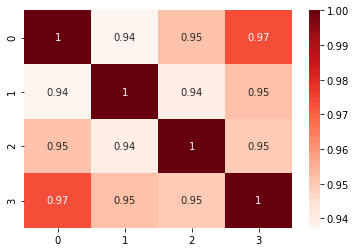

Ensemble-CV: 0.899616+0.00046749616754223304
best nrounds: 17
Ensemble-test 0.89294


In [38]:
ms = ModelStacking(X_train,
                   X_test,
                   X_final,
                   list(X_train.columns[:-1]),
                   models = [
#                        'et',
                       'rf',
                       'lr',
                       'cb',
                       'xgb',
                   ],
                   dep='satisfied',
                   nfolds=6,
                   seed=SEED
                  )
c = ms.stacking()
# X_train, y_train, X_test, y_test = ms.stacking()

In [34]:
rf-CV AUC is 0.88540
lr-CV AUC is 0.88041
cb-CV AUC is 0.89186
xgb-CV AUC is 0.89447

Ensemble-CV: 0.899616+0.00046749616754223304
best nrounds: 17
Ensemble-test 0.89294

SyntaxError: invalid syntax (<ipython-input-34-b340470c1f02>, line 1)

In [ ]:
rf-CV AUC is 0.88540
lr-CV AUC is 0.88041
cb-CV AUC is 0.89278
xgb-CV AUC is 0.89447

Ensemble-CV: 0.8996696666666666+0.0006414308657646523
best nrounds: 16
Ensemble-test 0.89282

In [ ]:
0.89254 : maxdepth = 2, reg=8

In [ ]:
rf-CV AUC is 0.88540
lr-CV AUC is 0.88041
cb-CV AUC is 0.89127
xgb-CV AUC is 0.89447

Ensemble-CV: 0.899242+0.0003968576571013734
best nrounds: 16
Ensemble-test 0.89246

In [26]:
rf-CV AUC is 0.88526
lr-CV AUC is 0.88040
cb-CV AUC is 0.89123
xgb-CV AUC is 0.89378

Ensemble-CV: 0.8981226666666666+0.0009133624082963409
Ensemble-test 0.89227

SyntaxError: invalid syntax (<ipython-input-26-c9dd22151830>, line 1)

In [ ]:
rf-CV AUC is 0.88594
lr-CV AUC is 0.88052
cb-CV AUC is 0.89114
xgb-CV AUC is 0.89342

Ensemble-CV: 0.8981666666666667+0.0008174926435278716
Ensemble-test 0.89210

In [ ]:
rf-CV AUC is 0.88429
lr-CV AUC is 0.88052
cb-CV AUC is 0.89119
xgb-CV AUC is 0.89362

Ensemble-CV: 0.897995+0.0007823149408433242
Ensemble-test 0.89220

In [ ]:
rf-CV AUC is 0.88642
lr-CV AUC is 0.88256
cb-CV AUC is 0.89214
xgb-CV AUC is 0.89454

Ensemble-CV: 0.8985756666666668+0.0007986873953904293
Ensemble-test 0.89056

In [113]:
rf-CV AUC is 0.88290
lr-CV AUC is 0.88248
cb-CV AUC is 0.89185
xgb-CV AUC is 0.89468

Ensemble-CV: 0.8986393333333335+0.0008557586627600466
Ensemble-test 0.89062

SyntaxError: invalid syntax (<ipython-input-113-f16ebe84ca91>, line 1)

In [ ]:
rf-CV AUC is 0.88394
lr-CV AUC is 0.88249
cb-CV AUC is 0.89170
xgb-CV AUC is 0.89410

Ensemble-CV: 0.8979755+0.0008324915915491524
Ensemble-test 0.89050

In [ ]:
rf-CV AUC is 0.87096
lr-CV AUC is 0.88266
cb-CV AUC is 0.89158
xgb-CV AUC is 0.89415

Ensemble-CV: 0.89802525+0.0010514574111679408
Ensemble-test 0.88970

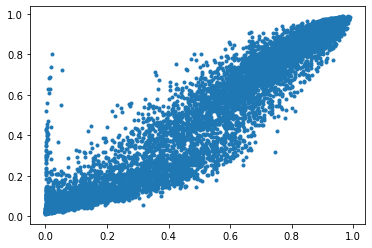

In [51]:
plt.plot(ms.models_oof_return['lr'][1], ms.models_oof_return['xgb'][1], '.')

In [24]:
c

array([0.15082465, 0.17467894, 0.8419113 , ..., 0.68889046, 0.66121787,
       0.15277079], dtype=float32)

In [25]:
test_ids = pd.read_csv("../data/interim/test.csv")["id"]

/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,6,10,12,21,24,35,85,87,88,89,100,124,126,127,128,130,131,133,166,172,177,193,194,195,205,206,207,220,222,228,229,230,240,257,258,260,261,262) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
result = pd.DataFrame()

In [27]:
result["Id"] = test_ids

In [28]:
result["Predicted"] = c

In [29]:
result.to_csv("../data/result/result_03_12_submission2.csv", index=False)

In [30]:
result

,Id,Predicted
0,14061,0.150825
1,16467,0.174679
2,25725,0.841911
3,9100,0.704058
4,32597,0.561604
...,...,...
9240,31430,0.826659
9241,3876,0.623197
9242,20710,0.688890
9243,26015,0.661218


In [ ]:
rf_params = {
    'n_jobs': 4,
    'n_estimators': 100,
    'max_features': 'sqrt',
    'max_depth': 24,
    'min_samples_leaf': 2,
}

In [71]:
imp = SimpleImputer(missing_values=MISSING, strategy='constant', fill_value=0)

In [72]:
XX = imp.fit_transform(X_train.drop(columns=["satisfied"]))

In [78]:
param_grid = {
    'max_features': ['sqrt'],
    'max_depth': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    'min_samples_leaf': [1,2,3],
}


# Create grid search object

clf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, 
                   scoring='neg_log_loss', cv = 6, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(XX, X_train["satisfied"])

Fitting 6 folds for each of 54 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  5.9min finished


In [79]:
best_clf.best_params_

{'max_depth': 29, 'max_features': 'sqrt', 'min_samples_leaf': 2}

In [80]:
pd.DataFrame(best_clf.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
43,8.522305,0.049916,0.135791,0.006915,29,sqrt,2,"{'max_depth': 29, 'max_features': 'sqrt', 'min...",-0.451800,-0.442233,-0.438911,-0.447883,-0.438292,-0.438068,-0.442865,0.005243,1
11,8.182439,0.042632,0.126133,0.004161,18,sqrt,3,"{'max_depth': 18, 'max_features': 'sqrt', 'min...",-0.446760,-0.444211,-0.437606,-0.448494,-0.439523,-0.440810,-0.442901,0.003910,2
7,8.425064,0.022363,0.135755,0.005721,17,sqrt,2,"{'max_depth': 17, 'max_features': 'sqrt', 'min...",-0.448079,-0.445943,-0.438546,-0.446450,-0.439440,-0.439853,-0.443052,0.003846,3
41,8.130432,0.037460,0.127878,0.006456,28,sqrt,3,"{'max_depth': 28, 'max_features': 'sqrt', 'min...",-0.452491,-0.445696,-0.435110,-0.447368,-0.437530,-0.440427,-0.443104,0.005988,4
26,8.060199,0.016051,0.132005,0.007652,23,sqrt,3,"{'max_depth': 23, 'max_features': 'sqrt', 'min...",-0.448604,-0.444156,-0.435314,-0.448834,-0.441672,-0.440201,-0.443130,0.004749,5
10,8.550341,0.094157,0.134419,0.004973,18,sqrt,2,"{'max_depth': 18, 'max_features': 'sqrt', 'min...",-0.450147,-0.443715,-0.438572,-0.445449,-0.441340,-0.439642,-0.443144,0.003897,6
31,9.389304,0.242655,0.138674,0.008693,25,sqrt,2,"{'max_depth': 25, 'max_features': 'sqrt', 'min...",-0.450205,-0.443751,-0.434103,-0.447916,-0.441053,-0.442058,-0.443181,0.005169,7
5,7.919444,0.045103,0.121687,0.001861,16,sqrt,3,"{'max_depth': 16, 'max_features': 'sqrt', 'min...",-0.449320,-0.444206,-0.436396,-0.447120,-0.441832,-0.440257,-0.443189,0.004294,8
37,8.563839,0.075119,0.134290,0.004533,27,sqrt,2,"{'max_depth': 27, 'max_features': 'sqrt', 'min...",-0.453225,-0.442581,-0.437297,-0.444458,-0.439457,-0.442261,-0.443213,0.005037,9
49,8.591599,0.304151,0.128384,0.001609,31,sqrt,2,"{'max_depth': 31, 'max_features': 'sqrt', 'min...",-0.451214,-0.445570,-0.438165,-0.447583,-0.438214,-0.439288,-0.443339,0.005074,10
